In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
import re
import ssl
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb

In [ ]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download necessary NLTK packages with explicit resources
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
except Exception as e:
    print(f"Error downloading NLTK data: {e}")

# Simple tokenizer that doesn't rely on punkt_tab
def simple_tokenize(text):
    """Simple tokenizer that doesn't use NLTK's punkt_tab"""
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Split by whitespace
    return text.split()

In [ ]:
# Step 1: Extended Sample Data (Patents, Trademarks, Copyrights)
data = {
    'text': [
        'This is a patent for a new machine learning algorithm that improves image recognition accuracy.',
        'Patent for a new drug formulation that enhances absorption and reduces side effects.',
        'A new algorithm patented by a tech company to optimize data storage in cloud computing systems.',
        'This patent describes a novel system for autonomous vehicle navigation using machine learning models.',
        'Trademark registered for a new logo design representing a global sportswear brand.',
        'Trademark infringement case filed for unauthorized use of a logo similar to an existing brand.',
        'A new logo design is trademarked for a tech startup specializing in AI-based solutions.',
        'Trademark application filed for a unique color scheme used in product packaging in the fashion industry.',
        'A copyright claim has been filed for a newly published novel on artificial intelligence.',
        'The new album by the artist is protected under copyright laws, preventing unauthorized distribution.',
        'This video documentary on marine biology is under copyright to prevent illegal reproduction.',
        'A book is protected under copyright laws, and the author retains the rights to all distribution.',
        'The company filed for a patent on an innovative solar energy panel technology.',
        'This trademark protects a unique music composition from unauthorized use.',
        'A copyright has been applied to a newly developed video game focusing on space exploration.',
        'A patent for a next-generation self-cleaning water filter technology.',
        'A trademark for a new beverage recipe introduced by a popular beverage company.',
        'Copyright protection for a new short film produced by an independent filmmaker.',
        'The patent covers an advanced algorithm for optimizing network traffic in large-scale systems.',
        'Trademark dispute filed for a symbol resembling a well-known tech company logo.',
    ],
    'label': ['patent', 'patent', 'patent', 'patent', 'trademark', 'trademark', 'trademark', 'trademark',
              'copyright', 'copyright', 'copyright', 'copyright', 'patent', 'trademark', 'copyright', 'patent',
              'trademark', 'copyright', 'patent', 'trademark']
}

In [ ]:
# Step 2: Convert the data into a DataFrame
df = pd.DataFrame(data)

# Step 3: Text Preprocessing Function
def clean_text(text):
    """
    This function cleans and preprocesses the input text with a robust approach
    that doesn't depend on problematic NLTK resources
    """
    # Lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)

    try:
        # Try using simple tokenization instead of NLTK tokenizer
        words = simple_tokenize(text)

        # Remove stopwords if available
        try:
            stop_words = set(stopwords.words('english'))
            words = [word for word in words if word not in stop_words]
        except:
            # If stopwords not available, continue without removing them
            pass

        # Try lemmatization if available
        try:
            from nltk.stem import WordNetLemmatizer
            lemmatizer = WordNetLemmatizer()
            words = [lemmatizer.lemmatize(word) for word in words]
        except:
            # If lemmatization fails, continue without it
            pass

        return ' '.join(words)
    except Exception as e:
        print(f"Text preprocessing error: {e}")
        # Return the basic cleaned text if all else fails
        return text

In [ ]:
 #Step 4: Apply text preprocessing to the dataset
df['cleaned_text'] = df['text'].apply(clean_text)

# Step 5: Split the data into train and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.2, random_state=42)

print("Training individual models instead of using GridSearchCV with ensemble...")

# Step 6: Define and train individual models
# Naive Bayes model
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
    ('nb', MultinomialNB(alpha=0.1))
])
nb_pipeline.fit(X_train, y_train)
nb_score = nb_pipeline.score(X_test, y_test)
print(f"Naive Bayes Accuracy: {nb_score:.4f}")

# Logistic Regression model
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
    ('lr', LogisticRegression(C=1.0, max_iter=1000))
])
lr_pipeline.fit(X_train, y_train)
lr_score = lr_pipeline.score(X_test, y_test)
print(f"Logistic Regression Accuracy: {lr_score:.4f}")

# SVM model
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
    ('svm', SVC(probability=True))
])
svm_pipeline.fit(X_train, y_train)
svm_score = svm_pipeline.score(X_test, y_test)
print(f"SVM Accuracy: {svm_score:.4f}")

# Random Forest model
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
    ('rf', RandomForestClassifier(n_estimators=100))
])
rf_pipeline.fit(X_train, y_train)
rf_score = rf_pipeline.score(X_test, y_test)
print(f"Random Forest Accuracy: {rf_score:.4f}")


Training individual models instead of using GridSearchCV with ensemble...
Naive Bayes Accuracy: 1.0000
Logistic Regression Accuracy: 0.2500
SVM Accuracy: 0.0000
Random Forest Accuracy: 0.2500


In [ ]:
# Find the best performing model
models = {
    'Naive Bayes': (nb_pipeline, nb_score),
    'Logistic Regression': (lr_pipeline, lr_score),
    'SVM': (svm_pipeline, svm_score),
    'Random Forest': (rf_pipeline, rf_score)
}

best_model_name = max(models.items(), key=lambda x: x[1][1])[0]
best_model, best_score = models[best_model_name]

print(f"\nBest model: {best_model_name} with accuracy: {best_score:.4f}")

# Save the best model
joblib.dump(best_model, 'ip_awareness_best_model.pkl')


Best model: Naive Bayes with accuracy: 1.0000


['ip_awareness_best_model.pkl']


Classification Report:
               precision    recall  f1-score   support

   copyright       1.00      1.00      1.00         1
      patent       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Confusion Matrix:
 [[1 0]
 [0 3]]
Accuracy: 1.0000


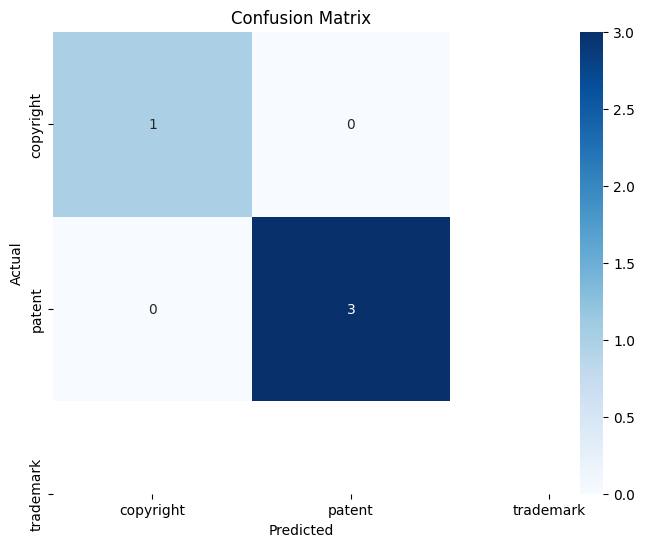

In [ ]:
# Step 7: Model Evaluation
# Predict using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

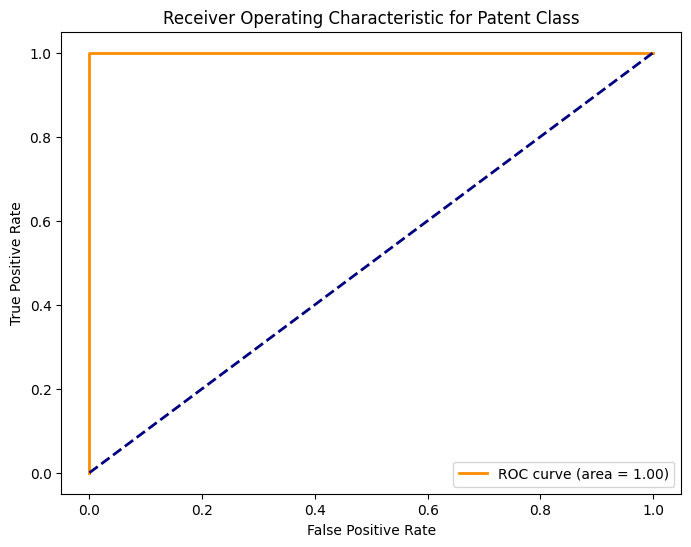

In [ ]:
# Get prediction probabilities if possible
if hasattr(best_model, 'predict_proba'):
    # For multiclass, focus on one class (e.g., 'patent')
    y_prob = best_model.predict_proba(X_test)

    # Find the index of the 'patent' class
    patent_idx = list(best_model.classes_).index('patent')

    # Create binary labels for 'patent' class
    y_test_bin = (y_test == 'patent').astype(int)

    # ROC curve for 'patent' class
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob[:, patent_idx])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for Patent Class')
    plt.legend(loc='lower right')
    plt.show()

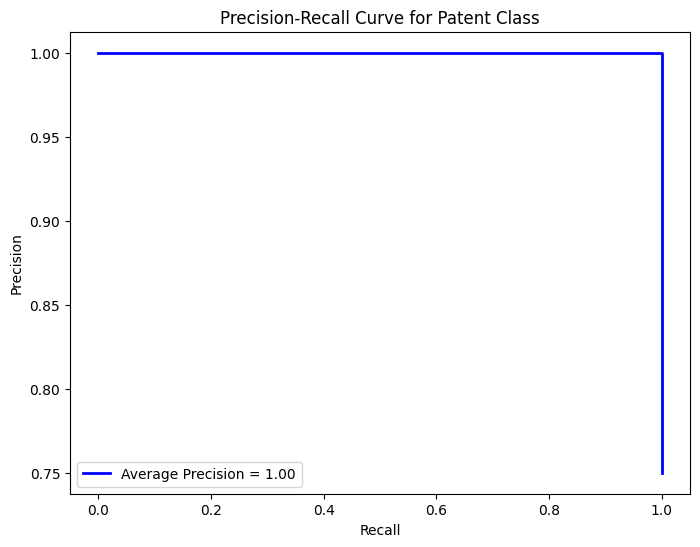


Testing new document:
Text: Patent for a new eco-friendly packaging solution that reduces waste and improves sustainability.
Predicted Category: trademark
Prediction Probabilities:
copyright: 0.1178
patent: 0.2454
trademark: 0.6368


In [ ]:
 # Precision-Recall curve for 'patent' class
precision, recall, _ = precision_recall_curve(y_test_bin, y_prob[:, patent_idx])
avg_precision = average_precision_score(y_test_bin, y_prob[:, patent_idx])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Patent Class')
plt.legend(loc='best')
plt.show()

# Step 8: Testing with a new document
new_document = ['Patent for a new eco-friendly packaging solution that reduces waste and improves sustainability.']
new_document_cleaned = clean_text(new_document[0])
prediction = best_model.predict([new_document_cleaned])
prediction_proba = best_model.predict_proba([new_document_cleaned])

print("\nTesting new document:")
print("Text:", new_document[0])
print("Predicted Category:", prediction[0])
print("Prediction Probabilities:")
for i, class_name in enumerate(best_model.classes_):
    print(f"{class_name}: {prediction_proba[0][i]:.4f}")